In [219]:
import pandas as pd
import os 
import matplotlib.pyplot as plt 
import re
import numpy as np
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


In [220]:
# load tree data 
df = pd.read_csv("data/df_tree.csv")
df.year = df.year.apply(int)
df.id = df.id.astype("category")
df = df[df['year']<2022]

# load district size 
df_size = pd.read_excel('raw_data/2022426114414371694040KKAREAL.xlsx', header=2, usecols = "B:K")
df_size = (df_size.dropna()).transpose()
df_size = df_size.reset_index()
df_size.rename(columns = {"index":'district', 0:'area_m2'}, inplace = True)
df_size['district'] = df_size['district'].str.replace("Bydel - ", "")
df_size['district'] = df_size['district'].str.replace("/", "-")
df_size['district'] = df_size['district'].str.replace("Kgs", "Kongens")
df_size['area_km2'] = df_size['area_m2']/(1000*1000)

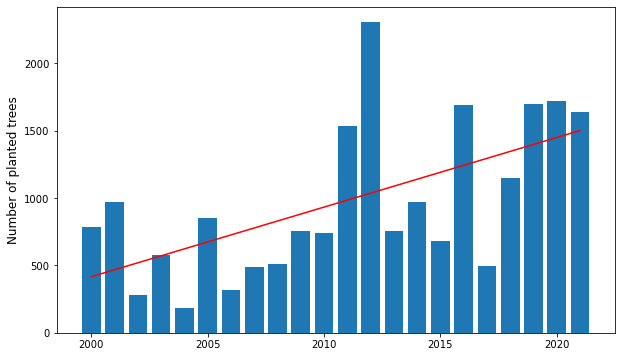

In [222]:
# Er der blevet plantet flere træer i Kbh siden 2000?
from scipy import stats
df_year = df.groupby(['year']).size()
# for trend curve
slope, intercept, r_value, p_value, std_err = stats.linregress(df_year.index.to_list(),df_year.values)

plt.figure(figsize=(10,6))
plt.bar(df_year.index,df_year.values)
plt.plot(df_year.index, slope*(df_year.index) + intercept, 'r-')
plt.ylabel('Number of planted trees',fontsize=12)
plt.show()

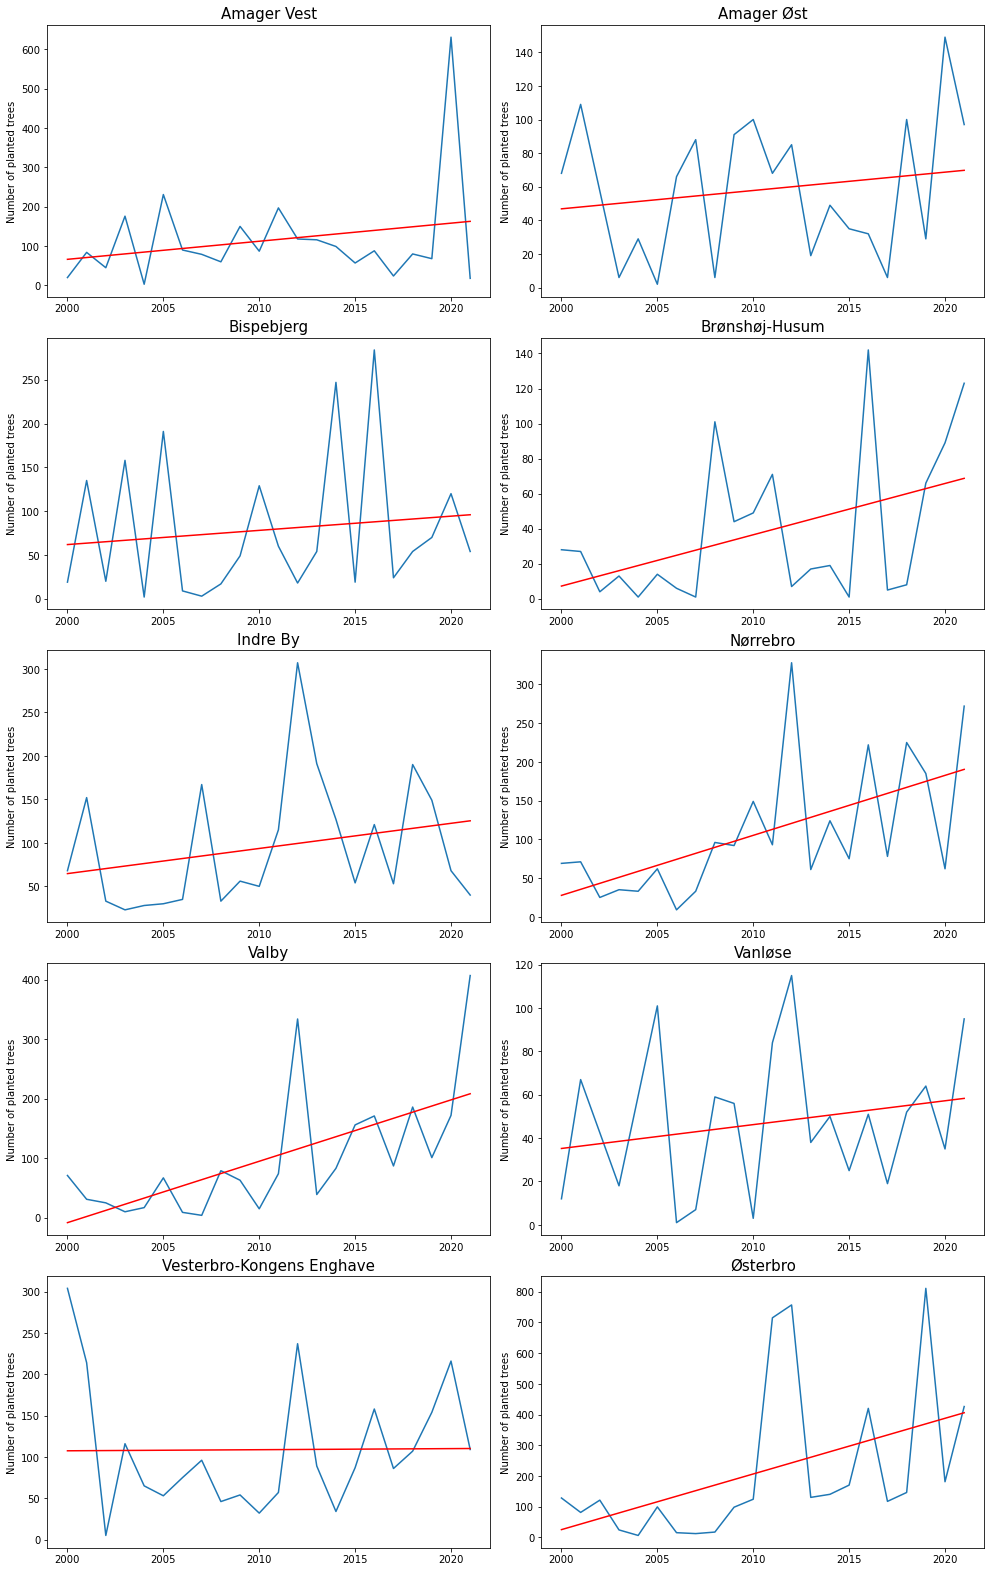

In [223]:
# Er der blevet plantet flere træer i de enkelte distrikter siden 2000?

# Bar plot of planted trees over the years in the different districts
df_districts = df.groupby(["year", "district"]).size().reset_index()
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize=(14,22))
figure.tight_layout(pad=2.0)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
districts = df_districts.district.unique()
for (ax, dist) in zip(axes, districts):
    temp = df_districts[df_districts["district"] == dist]
    slope, intercept, r_value, p_value, std_err = stats.linregress(temp['year'],temp[0])
    ax.plot(temp['year'],temp[0])
    ax.plot(temp['year'], slope*(temp['year']) + intercept, 'r-')
    ax.set_ylabel('Number of planted trees')
    ax.set_title(dist, fontsize=15)

In [224]:
# # Plot district sizes
# plt.figure()
# df_size = df_size.sort_values(by='area_km2',ascending=False)
# plt.xticks(rotation=90)
# plt.bar(df_size['district'],df_size['area_km2'])
# plt.show()

# How many trees in relation to area size 
df_rank = pd.DataFrame(index=df_districts.district.unique(),columns=['area_km2','tree_per_km2'])
for dist in districts:
    temp = df_districts[df_districts['year'] >= 2018]
    temp = temp[temp['district']==dist]
    area = (df_size[df_size['district']==dist]).area_km2
    df_rank.loc[dist,'area_km2'] = float(area)
    df_rank.loc[dist,'tree_per_km2'] = sum(temp[0])/float(area)
df_rank.sort_values(by='tree_per_km2',ascending=False)

,area_km2,tree_per_km2
Nørrebro,4.104694,181.255899
Østerbro,9.860777,158.608191
Valby,9.233781,93.786067
Vesterbro-Kongens Enghave,8.371719,69.997572
Indre By,9.432832,47.387677
Bispebjerg,6.832786,43.613249
Amager Vest,19.370227,41.14562
Amager Øst,9.784081,38.327565
Vanløse,6.698505,36.724612
Brønshøj-Husum,8.738408,32.729074


In [225]:
# Number of unique species in the districts 
df_unique_species = pd.DataFrame(index=districts, columns=['number_unique_species'])
df_species = df.groupby(['district','species']).count()
df_species = df_species.reset_index()
for dist in districts:
    df_unique_species.loc[dist,'number_unique_species'] = (df_species[df_species['district']==dist]).species.nunique()
df_unique_species

,number_unique_species
Amager Vest,32
Amager Øst,35
Bispebjerg,37
Brønshøj-Husum,28
Indre By,36
Nørrebro,74
Valby,38
Vanløse,24
Vesterbro-Kongens Enghave,41
Østerbro,68


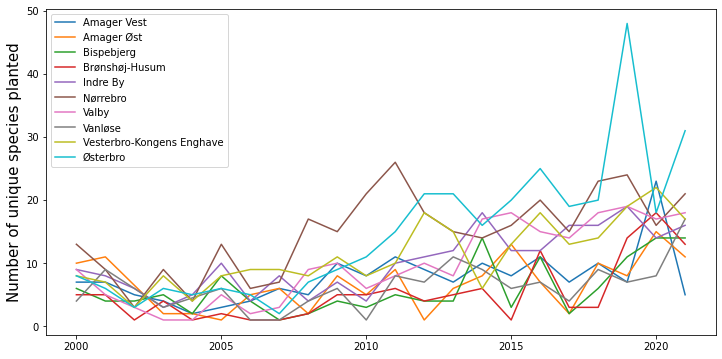

In [226]:
# Number of unique species in the districts over time  
# LAV BOKEH VERSION HVOR DISTRICT KAN VÆLGES 
df5 = df.groupby(['year','district','species']).count()
df5 =  df5.reset_index()

plt.figure(figsize=(12,6))
for dist in districts:
    temp = df5[df5["district"] == dist]
    temp2 = temp[['year','species']].groupby(['year']).nunique()
    plt.plot(temp2.index,temp2['species'])

plt.ylabel('Number of unique species planted',fontsize=15)
plt.legend(districts)
plt.title('', fontsize=15)
plt.show()

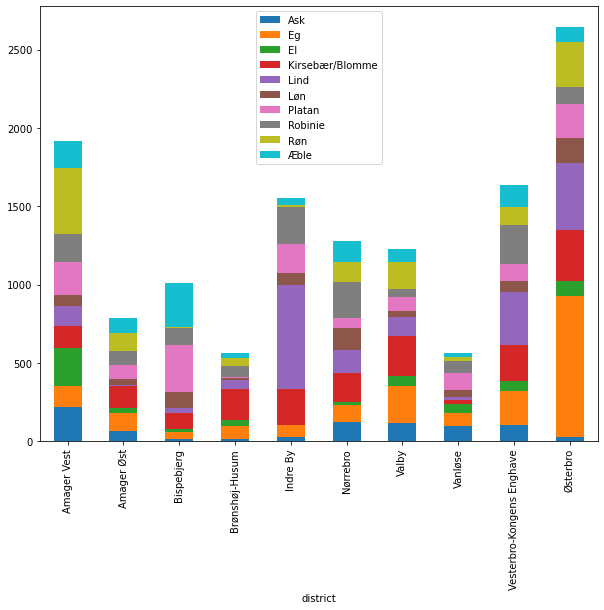

In [227]:
# Comapare distribution of top 10 species in the districts 
# Select 10 species individual for the districts 
# Make category for other 
df4 = df[df["species"].isin(tree_species)].groupby(['district','species']).size().reset_index()
df4new = (df4.pivot_table(0, ['district'], 'species')).reset_index()
df4new.plot(x='district',kind='bar',stacked=True,figsize=(10,8)).legend(loc='upper center')
plt.show()

In [155]:
# Heat map showing planted years over time
heat_data = pd.DataFrame()
heat_data[['Y','X', "Weight"]] = df[['Y','X', "year"]]
heat_data['Weight'] = heat_data['Weight'].astype(float)
heat_data = heat_data.dropna(axis=0, subset=['Y','X', 'Weight'])
heat_data = [[[row['Y'],row['X']] for index, row in heat_data[heat_data['Weight'] == i].iterrows()] for i in range(2000,2023)]

# Plot it on the map
lat = 55.6761
lon = 12.5683
map = folium.Map(location=[lat, lon],zoom_start = 12)
hm = HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map)
map